In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import shutil
from sklearn.datasets import load_files
import shutil,os,glob
import random
from collections import Counter
import cv2
from PIL import Image

from keras import models, layers, optimizers
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import math

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [3]:
df_bbox = pd.read_csv('../../data/BBox_List_2017.csv')
df_bbox.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [4]:
df_bbox[df_bbox['Image Index'] == '00018387_030.png']

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
174,00018387_030.png,Cardiomegaly,388.881356,358.273454,495.728814,295.050847,NaN,NaN,NaN
342,00018387_030.png,Effusion,158.720000,441.780156,769.137778,160.426667,NaN,NaN,NaN


In [5]:
bbox_list = df_bbox['Image Index']
full_list = bbox_list.tolist()
train_list = []
test_list = []

for index, image in enumerate(full_list):
    if index % 5 == 0:
        test_list.append(image)
    else:
        train_list.append(image)

In [6]:
# bbox_list = df_bbox['Image Index']
# train_list = bbox_list.tolist()
# test_list = []

# for index, image in enumerate(train_list):
#     if index % 5 == 0:
#         test_list.append(train_list.pop(index))

In [7]:
print(len(train_list), len(test_list), len(test_list)/(len(test_list) + len(train_list)))

787 197 0.20020325203252032


In [8]:
counter = 0
for train in train_list:
    if train in test_list:
        counter += 1
counter

42

In [9]:
df_bbox_train = df_bbox.loc[df_bbox['Image Index'].isin(train_list)]
df_bbox_train.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
6,00012515_002.png,Atelectasis,289.084746,638.137861,83.525424,56.406780,NaN,NaN,NaN


In [10]:
df_bbox_test = df_bbox.loc[df_bbox['Image Index'].isin(test_list)]
df_bbox_test.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
5,00003148_004.png,Atelectasis,596.067797,505.780787,56.406780,180.067797,NaN,NaN,NaN
10,00030674_000.png,Atelectasis,632.949153,251.968369,227.796610,210.440678,NaN,NaN,NaN
15,00028452_001.png,Atelectasis,629.694915,410.341251,256.000000,148.610169,NaN,NaN,NaN
20,00000468_033.png,Atelectasis,204.474576,502.544640,116.067797,53.152542,NaN,NaN,NaN


In [11]:
df_bbox['Finding Label'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

In [12]:
df_bbox_train['Finding Label'].value_counts()

Atelectasis     151
Effusion        130
Cardiomegaly    118
Infiltrate      108
Pneumonia       101
Pneumothorax     79
Mass             72
Nodule           63
Name: Finding Label, dtype: int64

In [13]:
df_bbox_test['Finding Label'].value_counts()

Effusion        42
Atelectasis     39
Infiltrate      35
Cardiomegaly    33
Pneumonia       31
Pneumothorax    22
Mass            21
Nodule          16
Name: Finding Label, dtype: int64

### Train Test Split

In [337]:
def train_test_split(train_test):
    dest = '../../imgs/bbox'
    if not os.path.exists(os.path.join(dest, train_test)):
        os.mkdir(os.path.join(dest, train_test))

    else:
        pass

def split_items(train_val_test_list, category):
    try:
        dest = os.path.join('../../imgs/bbox', category)
        for item in train_val_test_list:
            _from = os.path.join('../../imgs/bbox', item)
            folder = df_bbox.loc[df_bbox['Image Index'] == item, 'Finding Label'].values[0]  # Disease
            if not os.path.exists(os.path.join(dest, folder)):
                os.mkdir(os.path.join(dest, folder))
                shutil.copy(_from, os.path.join(dest, folder))
            else:
                shutil.copy(_from, os.path.join(dest, folder))
    except Exception as e:
        print(e)

In [338]:
# Through function
train_test_split('train')
train_test_split('test')
        
split_items(train_list, 'train')
split_items(test_list, 'test')

In [339]:
# Create folders
def create_folders(train_test):
    path = '../../imgs/crops'
    dest = os.path.join(path, train_test) 
    categories = df_bbox_test['Finding Label'].unique()
    for category in categories:
        os.mkdir(os.path.join(dest, category))
    return

In [340]:
# Create folders
create_folders('train')
create_folders('test')

## Crop BBOX

In [344]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    """Returns the path and the Label from the folder"""
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 8)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../imgs/bbox/train')
test_files, test_targets = load_dataset('../../imgs/bbox/test')

In [345]:
def save_bbox(train_test_files, folder):
    _FROM = "../../imgs/crops"
    if folder == 'train':
        _ = 0
    else:
        _ = 1
    for element in train_test_files:
        label = element[(22 - _):-17]
        photo = element[-16:]
        img = cv2.imread(element)
        
        x, y, w, h = df_bbox.loc[df_bbox['Image Index'] == photo, ['Bbox [x', 'y', 'w', 'h]'] ].values[0]
        x, y, w, h = int(x), int(y), int(w), int(h)
        y_h = y + h
        x_w = x + w
        
        crop_img = img[y:y_h, x:x_w]
        dest = os.path.join(_FROM, folder, label, photo)
        cv2.imwrite(dest, crop_img)
            
    return

In [346]:
# Split Crop pictures
save_bbox(train_files, 'train')
save_bbox(test_files, 'test')

## Tests

In [32]:
df_bbox.columns

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [104]:
df_bbox.loc[df_bbox['Image Index'] == '00000147_001.png',:]

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
119,00000147_001.png,Atelectasis,617.650794,599.22963,100.774603,179.877249,NaN,NaN,NaN


In [347]:
img = cv2.imread(r"C:\Users\micka\Mike\Coding\ITC Code\Projet DS\mika_local\imgs\images\00010767_016.png")
pict = '00010767_016.png'

In [348]:
x,y,w,h = df_bbox.loc[df_bbox['Image Index'] == pict, ['Bbox [x', 'y', 'w', 'h]'] ].values[0]
x,y,w,h = int(x), int(y), int(w), int(h)

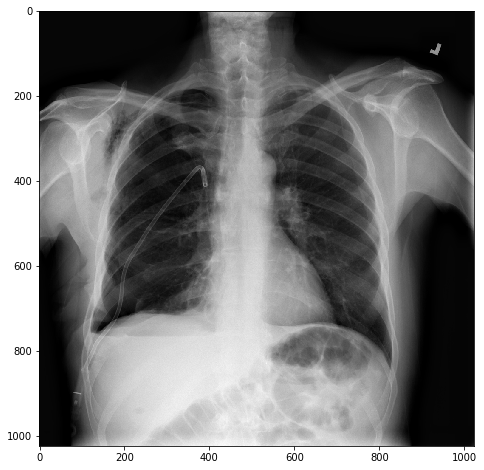

In [349]:
plt.figure(figsize=(10,8))
plt.imshow(img)

In [350]:
x, y, w, h

(117, 177, 311, 591)

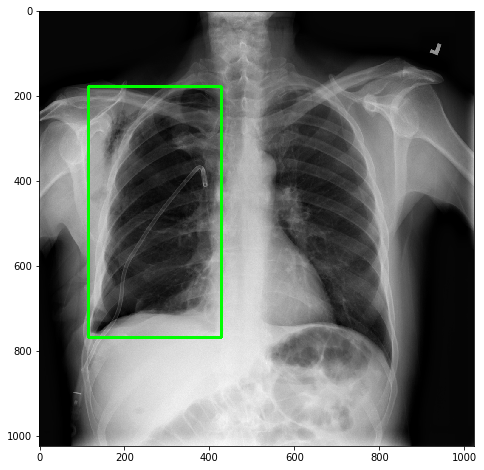

In [351]:
y_h = y + h
x_w = x + w


rect = cv2.rectangle(img, (x, y), (x_w, y_h), (0,255,0), 5) # image/ coordinates/ color/width 
plt.figure(figsize=(10,8))
plt.imshow(rect)

### Save Croped image

In [335]:
x, y, x_w, y_h

(802, 281, 895, 386)

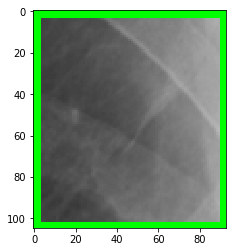

In [336]:
crop_img = img[y:y_h, x:x_w]
plt.imshow(crop_img)

In [320]:
crop_img

array([], shape=(676, 0, 3), dtype=uint8)

In [125]:
cv2.imwrite("../../imgs/test/mika.png", crop_img)a

True

In [267]:
crop_img.shape

(179, 100, 3)